In [1]:
import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import pinv
import matplotlib.pyplot as plt

import copy
import random

In [2]:
# This part of the code implements live plotting:

from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict,
              title, ylabel=None,
              xlabel=None, figsize=(15,5),
              data_dict2=None,
              ylabel2=None,
              xlabel2=None):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    if data_dict2:
        plt.subplot(1,2,1)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if data_dict2:
        plt.subplot(1,2,2)
        for label,data in data_dict2.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.xlabel(xlabel2)
        plt.ylabel(ylabel2)
        plt.legend()
    plt.show();

In [3]:
# defining the graph (weighted with rewards):

R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])

NumbertoSAPair = np.array([[0, 0],[0,4],
                           [1,1],[1,3],[1,5],
                           [2,2],[2,3],[3,1],[3,2],[3,3],
                           [3,4],[4,0],[4,3],[4,4],[4,5],
                           [5,1],[5,4],[5,5]])

AlenVec = np.array([2,3,2,4,4,3])

# Inverse mapping: Given state-action pair, what is the curresponding number:
SAPairtoNumber = -1*np.ones((6,6))

for i in range(len(NumbertoSAPair)):
    SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
    
StaActLen = np.sum(AlenVec); # Total number of state action pairs

In [4]:
def compute_Bellman_error(q_table, beta, noise):

    #Initialize Bellman error to 0:
    BE = np.zeros(StaActLen) # initialiser BE_Zap avec des 0
    
    for jj in range(StaActLen): # pour tous les state-action possibles

        x = NumbertoSAPair[jj,0] # x = state(jj)
        a = NumbertoSAPair[jj,1] # a = action(jj)

        # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
        max_Qfun_xtp1_Zap = 0; # max_Qfun_xtp1_Zap initialisé à 0
        NumOfXtp1 = 0; # NumOfXtp1 initialisé à 0
        for ll in range(StaActLen): # pour tous les state-action possibles ll
            if(NumbertoSAPair[ll,0] == x): # si ll part de state(jj)
                xplus1 = NumbertoSAPair[ll,1] # xplus1 prend action(ll)
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + np.max(q_table[xplus1]) # max_Qfun_xtp1_Zap += max q_table à partir de action(ll)
                NumOfXtp1 = NumOfXtp1 + 1 # NumOfXtp1++
        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1 # max_Qfun_xtp1_Zap /= NumOfXtp1 (ie on prend l'average de toutes les greedy policies à partir de x)

        # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
        BE[jj] = R[x,a] + beta*((1-noise)*np.max(q_table[a]) +  noise*max_Qfun_xtp1_Zap) - q_table[x,a]

    # MaximalBellmanError = max_{x,a} BE(x,a):  
    return np.max(abs(BE))

In [5]:
import math

def epsilon_greedy_policy(x, adjacencyMatrix, QTable, epsilon=0, environmentAwareness=False):
    """
    Returns action a (:= next wanted step in this problem)
    Takes greedy action with proba 1-epsilon
    adjacencyMatrix is the weighted reward matrix with -100 where no edges
    it will not be taken into account if environmentAwareness=False (then agent can choose -100 edges)
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > epsilon:
            return np.argmax(QTable[x])
        else:
            return np.random.choice(range(QTable[x].shape[0]))
    else:
        if r > epsilon:
            imax = -1
            Qmax = -1 * math.inf
            for i in range(QTable[x].shape[0]):
                if adjacencyMatrix[x][i] > -100 and QTable[x][i] > Qmax:
                    imax = i
                    Qmax = QTable[x][i]
            assert imax > -1, "Error : no possible action"
            return imax
        
        else:
            available = []
            for i in range(adjacencyMatrix[x].shape[0]):
                if adjacencyMatrix[x][i] > -100:
                    available.append(i)
            assert not len(available) == 0, "Error : no possible action"
            return np.random.choice(available)

In [6]:
def take_action(x, a, adjacencyMatrix, environmentAwareness=True, randomness=0.5):
    """
    Environment response to the action a from state x, returns: newState, reward
    when environmentAwareness=True, only possible actions will be randomly taken in case of random failure
    """
    #print('randomness:', randomness, 'received x:', x, 'received a:', a)
    r = np.random.rand()
    if not environmentAwareness:
        if r > randomness:
            #print('not environmentAwareness, r > rand')
            return a, adjacencyMatrix[x][a]
        else:
            #print('not environmentAwareness, r <= rand')
            aa = np.random.choice(range(adjacencyMatrix[x].shape[0]))
            return aa, adjacencyMatrix[x][aa]
    else:
        available = []
        for i in range(adjacencyMatrix[x].shape[0]):
            if adjacencyMatrix[x][i] > -100:
                available.append(i)
        assert not len(available) == 0, "Error : no possible action"
        if r > randomness:
            assert a in available, "Error : the action in not possible"
            #print('environmentAwareness, r > rand')
            return a, adjacencyMatrix[x][a]
        else:
            #print('environmentAwareness, r <= rand')
            aa = np.random.choice(available)
            return aa, adjacencyMatrix[x][aa]

In [7]:
# tests

#print(take_action(1, 5, R, environmentAwareness=False, randomness=0))
#print(take_action(1, 5, R, environmentAwareness=False, randomness=1))
#print(take_action(1, 1, R, environmentAwareness=True, randomness=0))
#print(take_action(1, 0, R, environmentAwareness=True, randomness=1))

#x = 1
#a = epsilon_greedy_policy(x, R, QTable, epsilon=1, environmentAwareness=True)
#print(a)
#print(take_action(x, a, R, environmentAwareness=True, randomness=0))

In [8]:
def compute_max_real_part_eigenvalue(M): # computes the max real part of the eigenvalues of matrix M
    return np.max(np.real(np.linalg.eig(M)[0]))

In [9]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    dataplot = collections.defaultdict(list) # history of Bellman Errors to plot
    dataplot2 = collections.defaultdict(list) # history of max eigenvalues of GA to plot
    xt = xStart; # start in state 0
    noise = environmentRandomness
    R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])
    
    AlenVec = np.array([2,3,2,4,4,3]) # Number of actions in each state; Ex: 2 = number of actions in state 0.

    # We need a mapping from state-action pair to a number between 1 and 18
    # This array is precisely that mapping
    # E.g. [State 0, Action 0] corresponds to the zeroeth state-action pair, 
    # [State 0, Action 4] corresponds to the first state-action pair

    NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

    # Location of the state-action pair indicates the unique number which represents this pair (e.g. [5 5] = 17)

    # Inverse mapping: Given state-action pair, what is the curresponding number:
    SAPairtoNumber = -1*np.ones((6,6))

    for i in range(len(NumbertoSAPair)):
        SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
        
    StaActLen = np.sum(AlenVec); # Total number of state action pairs

    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*np.eye(StaActLen)

    # Initialize the parameter vector for Zap Q:
    Qthetat_ZapQ = np.random.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = np.zeros((6,6))

    # Q-learning begins here:

    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        # ChooseAction will return the random action chosen in the current state AND the next state
        #xtp1at_m = ChooseAction(xt,noise,Qfun_ZapQ)
        at = epsilon_greedy_policy(xt,
                                   R,
                                   Qfun_ZapQ,
                                   epsilon=epsilon,
                                   environmentAwareness=policyEnvironmentAwareness)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              environmentAwareness=environmentEnvironmentAwareness,
                              randomness=environmentRandomness)
        #print(at)
        #print(xtp1)
        #break

        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psixtat = np.zeros(StaActLen)
        psixtat[num_sa_pair] = 1; # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        psixtp1 = np.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1[int(SAPairtoNumber[xtp1,jj])] = 1 # Take value 1


        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = np.dot(Qthetat_ZapQ,psixtat)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:
        Qxtp1_Zap = np.multiply(Qthetat_ZapQ,psixtp1)

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = np.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        max_Qxtp1_Zap = np.max(Qxtp1_Zap)
        # max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = np.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        A_ZapQ = A_ZapQ + gammat*( ( - np.outer(psixtat,psixtat) + beta*np.outer(psixtat,psixtp1_OptAct)) - A_ZapQ)
        Ainv_ZapQ = np.linalg.pinv(A_ZapQ)

        # Q update for SNR 2 (a) gain:
        Qthetat_ZapQ  =  Qthetat_ZapQ  - alphat*(np.dot(Ainv_ZapQ,psixtat))*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration
        
        for jj in range(StaActLen):
            Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Qthetat_ZapQ[jj]
        if((t%t_step)==0):
            # MaximalBellmanError = max_{x,a} BE(x,a):  
            dataplot['Zap_Q'].append(compute_Bellman_error(Qfun_ZapQ, beta, noise))
            dataplot2['Zap_Q'].append(compute_max_real_part_eigenvalue(A_ZapQ))
            #dataplotMaxEV['Zap_Q'].append(compute_max_real_part_eigenvalue())
            if livePlot:
                live_plot(dataplot,
                          title=plotTitle,
                          ylabel='Bellman error',
                          xlabel='t',
                          data_dict2=dataplot2,
                          ylabel2='Max Re(lambda) of A',
                          xlabel2='t')

            # End of calculating Bellman Error
    if not livePlot:
        live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return Qfun_ZapQ

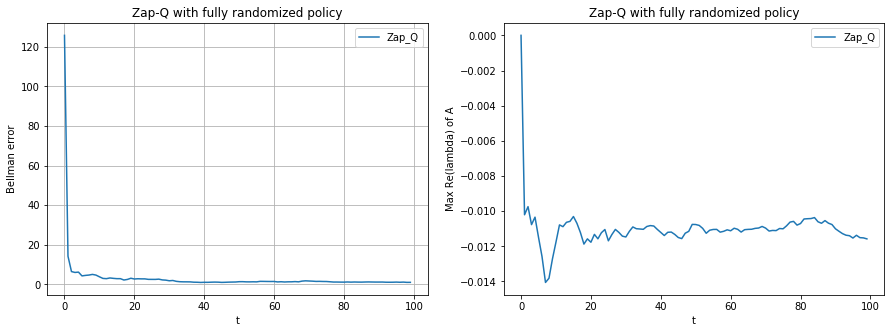

[[310.28225525   0.           0.           0.         376.13432823
    0.        ]
 [  0.         385.68867469   0.         306.35148246   0.
  489.6148309 ]
 [  0.           0.         237.10570389 287.27328834   0.
    0.        ]
 [  0.         373.7494636  245.5153892  305.17115971 373.29265245
    0.        ]
 [304.73946599   0.           0.         302.9341171  381.18897767
  487.50140459]
 [  0.         386.9212078    0.           0.         385.53857599
  495.82931135]]


In [10]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with fully randomized policy')

print(Q)

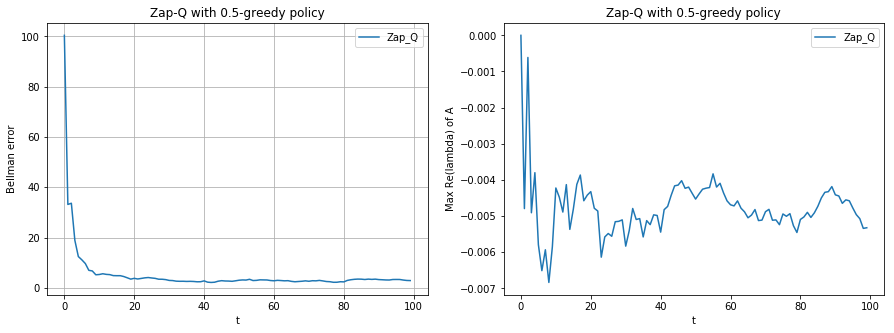

[[309.44653088   0.           0.           0.         374.66370353
    0.        ]
 [  0.         385.80107667   0.         306.65463563   0.
  489.81441326]
 [  0.           0.         237.39915322 288.0971557    0.
    0.        ]
 [  0.         374.34958664 245.9207696  304.76685395 368.8775382
    0.        ]
 [304.70747513   0.           0.         303.5153658  380.09425978
  486.23426145]
 [  0.         387.00032961   0.           0.         384.62077824
  495.75520845]]


In [11]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 0.5-greedy policy')

print(Q)

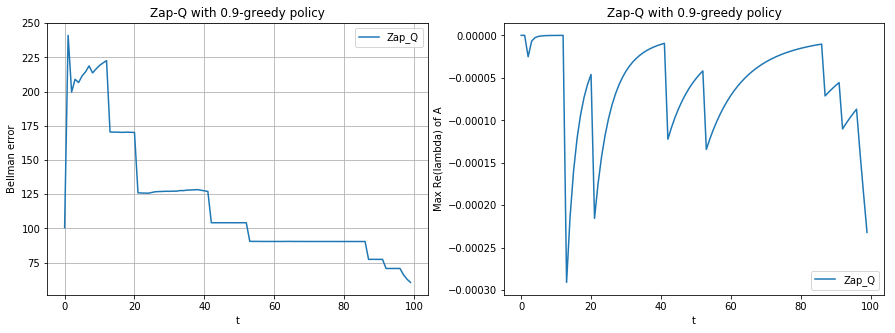

[[294.49195671   0.           0.           0.         372.04119023
    0.        ]
 [  0.         384.28254168   0.         306.15783475   0.
  488.78582048]
 [  0.           0.         174.29084484 284.6762916    0.
    0.        ]
 [  0.         372.19148286 243.35572653 299.69370868 354.13857728
    0.        ]
 [300.49121773   0.           0.         299.357742   375.46728398
  485.38385198]
 [  0.         386.05491975   0.           0.         383.17727541
  495.15205412]]


In [12]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 0.9-greedy policy')

print(Q)

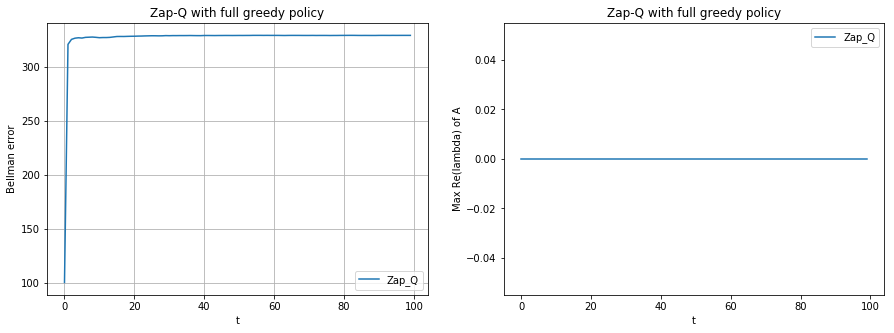

[[ 2.06788656e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.01547915e+02  0.00000000e+00]
 [ 0.00000000e+00  1.72245269e-01  0.00000000e+00  6.17008463e-01
   0.00000000e+00  2.66093874e+02]
 [ 0.00000000e+00  0.00000000e+00  5.20766802e+01 -2.85748377e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.97049839e+02  3.91935249e+01  5.63779181e-01
   3.51287170e-01  0.00000000e+00]
 [ 2.85133226e+01  0.00000000e+00  0.00000000e+00  1.35332257e-02
   3.68079013e-01  2.65182283e+02]
 [ 0.00000000e+00 -1.24385871e+02  0.00000000e+00  0.00000000e+00
   2.03968217e+02 -3.86912603e+01]]


In [13]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with full greedy policy')

print(Q)

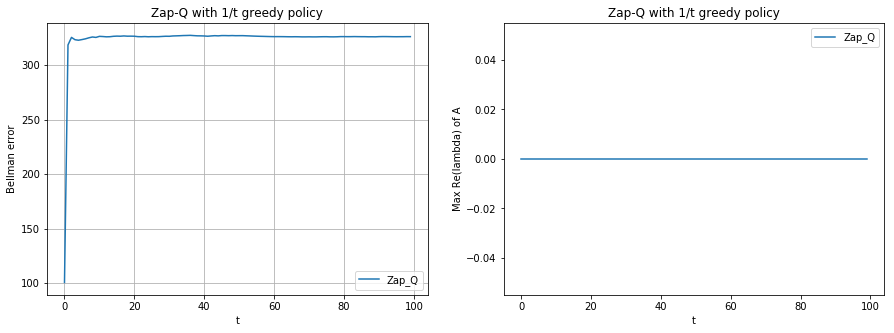

[[ 6.32844487e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.29723999e+01  0.00000000e+00]
 [ 0.00000000e+00  3.33521556e+01  0.00000000e+00 -4.98555054e+00
   0.00000000e+00  2.81642808e-02]
 [ 0.00000000e+00  0.00000000e+00  9.85663817e+00 -9.97303170e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -8.12084266e+00  8.36647532e+00  3.39085895e+01
  -1.01145576e+01  0.00000000e+00]
 [ 4.81881862e+01  0.00000000e+00  0.00000000e+00 -8.97278032e+00
   2.03802676e+01  2.19913944e+02]
 [ 0.00000000e+00  4.65142536e+01  0.00000000e+00  0.00000000e+00
   1.57495974e+02 -1.03601274e+02]]


In [14]:
Q = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=-1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle='Zap-Q with 1/t greedy policy')

print(Q)

In [15]:
# vanilla Q learning :

def vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 100000,
                       iter_max = 10,
                       policyRandomness = 0,
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=0,
                       plotTitle=None):
    np.random.seed(seed)
    BE = np.zeros((6,6))
    xt1 = 4
    dataplot = collections.defaultdict(list)
    #print ('----- using Q Learning -----')
    q_table = np.zeros((6,6))
    for i in range(iter_max):
        obs = xt1
        total_reward = 0
        for j in range(t_max):
            alpha = 1/(j+1)
            #alpha = max(min_lr, initial_lr * (0.85 ** (j//100)))
            xt0 = xt1
            #print('---\n state ', xt0)
            #print('qtable initiale \n', q_table)
            action = epsilon_greedy_policy(xt0,
                                   R,
                                   q_table,
                                   epsilon=policyRandomness,
                                   environmentAwareness=policyEnvironmentAwareness)
            #print('chosen action ', action)
            xt1, reward = take_action(xt0,
                                  action,
                                  R,
                                  environmentAwareness=environmentEnvironmentAwareness,
                                  randomness=environmentRandomness)
            #print('new state ', xt1, ', reward ', reward)
            total_reward += (gamma ** j) * reward
            # update q table
            q_table[xt0][action] = q_table[xt0][action] + alpha * (reward + gamma *  np.max(q_table[xt1]) - q_table[xt0][action])
            #print('qtable updated \n', q_table)
            if j%10000 == 0:
                dataplot['Vanilla_Q'].append(compute_Bellman_error(q_table, gamma, environmentRandomness))
                if livePlot:
                    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return q_table

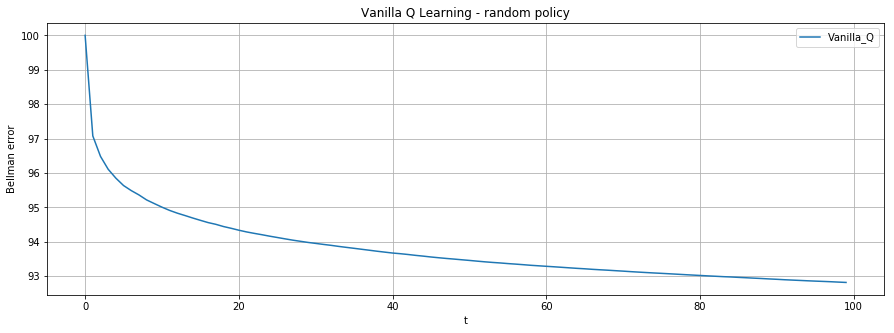

[[ 1.23332298e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.52058297e+00  0.00000000e+00]
 [ 0.00000000e+00  1.40719929e+01  0.00000000e+00  3.72799515e+00
   0.00000000e+00  5.22338757e+01]
 [ 0.00000000e+00  0.00000000e+00 -4.84128010e-02 -7.77285646e-01
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  8.61364620e+00 -7.78572004e-01  1.77491321e+00
   5.07043111e+00  0.00000000e+00]
 [ 1.04408007e-01  0.00000000e+00  0.00000000e+00 -1.01733581e+00
   1.01222899e+01  4.53417979e+01]
 [ 0.00000000e+00  1.28287297e+01  0.00000000e+00  0.00000000e+00
   9.68768598e+00  4.04182880e+01]]


In [16]:
q_table = vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1000000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 1, # full random
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       plotTitle='Vanilla Q Learning - random policy')

print(q_table)

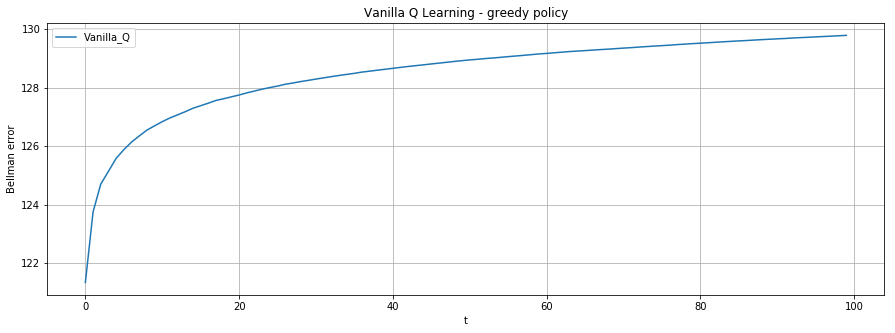

[[19.70023081  0.          0.          0.          0.          0.        ]
 [ 0.         -1.66666667  0.         -0.83333333  0.         37.59242283]
 [ 0.          0.          0.99092603  0.          0.          0.        ]
 [ 0.         -1.25        9.04562521  0.          0.          0.        ]
 [40.04693769  0.          0.          0.          0.          0.        ]
 [ 0.         -2.5         0.          0.         35.46058023  0.        ]]


In [17]:
q_table = vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1000000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 0, # full greedy
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.8,
                       seed=1,
                       plotTitle='Vanilla Q Learning - greedy policy')

print(q_table)